# DESI MWS SV ANALYSIS

* Reads the data generated by `sv_design.ipynb`

In [88]:
RUN_NAME = 'single_dark_tile'

In [2]:
# %load scripts/nbpreamble.py
if not 'RUN_NAME' in locals():
    RUN_NAME = 'unknown'

import sys
import os
import shutil
import glob
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))
        
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

# Write all the files under this path
ROOT_DIR  = os.getcwd()
WORK_ROOT = os.path.join(ROOT_DIR,'runs',RUN_NAME)
print('Files will be written under {}'.format(WORK_ROOT))

if not os.path.exists(WORK_ROOT):
    os.makedirs(WORK_ROOT)
    
print()
print('Files under this directory:')
!tree --noreport -C --filelimit 10 -I '*.py*' $ROOT_DIR

print()
print('Files under the run directory:')
!date
!tree --noreport -C -D --filelimit 10 $WORK_ROOT/run

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

# Set up paths
rundir   = os.path.join(WORK_ROOT,'run')
datadir  = os.path.join(rundir,'data')
outdir   = os.path.join(rundir,'output')

for _dir in [rundir,datadir,outdir]:
    os.makedirs(_dir,exist_ok=True)  
    
resource_paths = {
     "skies"  : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
     "gfas"   : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

resource_names = {
    "skies"   : "dr7.1-0.22.0.fits", 
    "gfas"    : "dr7.1.fits",
}

mtl_path           = os.path.join(datadir, 'mtl.fits')
std_path           = os.path.join(datadir, 'std.fits')
local_targets_path = os.path.join(datadir, 'sv_targets.fits')

sky_path     = os.path.join(resource_paths["skies"], 
                          "skies-{}".format(resource_names["skies"]))
gfa_path     = os.path.join(resource_paths["gfas"], 
                          "gfas-{}".format(resource_names["gfas"]))

Tue Dec 11 16:20:56 PST 2018
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.25.0.dev2587      
desimodel       0.9.9.dev464        
fiberassign     0.10.3.dev2254

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan
Files will be written under /global/u1/a/apcooper/projects/mws_svplan/runs/unknown

Files under this directory:
/global/u1/a/apcooper/projects/mws_svplan
├── cache
│   └── sweeps
│       └── 7.1 [292 entries exceeds filelimit, not opening dir]
├── py
│   └── apcsv
│       └── __pycache__
├── runs
│   ├── single_dark_tile
│   │   ├── run
│   │   │   ├── data
│   │   │   │   ├── mtl.fits
│   │   │   │   ├── std.fits
│   │   │   │   └── sv_targets.fits
│   │   │   └── output
│   │   │       └── tile_00000.fits
│   │   └── tiles
│   │       └── mws_sv_tiles.fits
│   ├── single_hex_bright
│   │   ├

Patch in our own targetmask (for analysis, no need to patch the cut logic).

In [3]:
import apcsv.patch
reload(apcsv.patch)
from apcsv.patch import patch_desitarget_bits

# Restores targetmask to default
reload(desitarget)
reload(desitarget.targetmask)

# Patch with our definitions
new_yaml = os.path.join(WORK_ROOT,'targetmasks/mws_sv_fix_targetmask.yaml')
desi_mask, bgs_mask, mws_mask, obsmask, obsconditions = patch_desitarget_bits(desitarget,
                                                                              new_yaml)

FileNotFoundError: [Errno 2] No such file or directory: '/global/u1/a/apcooper/projects/mws_svplan/runs/unknown/targetmasks/mws_sv_fix_targetmask.yaml'

In [ ]:
import apcsv.util
reload(apcsv.util)
import apcsv.fiberqa
reload(apcsv.fiberqa)

In [ ]:
# Read the outputs of the fiberassign python script (post-processed/value-added 
# versions of raw output from fiberassign_exec). There are 3 extensions.
fib = apcsv.fiberqa.load_fiber_data(outdir,'FIBERASSIGN')
pot = apcsv.fiberqa.load_fiber_data(outdir,'POTENTIAL')
tgt = apcsv.fiberqa.load_fiber_data(outdir,'TARGETS')

Analysis of a single tile.

In [17]:
t = Table(fib[0])
t[0:2]

FIBER,LOCATION,NUMTARGET,PRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,SUBPRIORITY,HPXPIXEL,NUMOBS_MORE,OBSCONDITIONS
int32,int32,int16,int32,int64,int64,int64,int64,float64,float64,float32,float32,str8,int32,float32,float32,float32,str3,int16,int32,int32,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,str1,float64,int64,int32,int32
0,95,19,1550,30787732330513601,2305843009213693952,0,114688,177.098874401,0.68599058683,-3.86455,-173.316,1771p007,0,268.723,173.399,5400.0,TGT,0,95,7000,335396,1217,PSF,2.80398e+11,2.74448e+11,9827.4 .. 0.0,0.0267484,1.85021,3.02529,3.55407,0.363519,0.697065,66.8079,387.859,881.071,596.291,107.205,2.60017,0.499807,0.000888583,1.92848e-05,0.923873,0.94806,0.970606,0.995477,0.99722,0.999406,0.999776,4,4,4,0.0,0.0,0.0,0.0153124,0.0117231,0.0213754,0.995449,0.996113,0.995649,0,0,0,1055.44,779.796,112.614,744.317,436.852,60.3867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.43829,2.35175,2.76281,1.4388,2.35465,2.77044,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,False,S,0.218861715596,26972,1,7
1,62,10,2000,30787732334709212,3458764513820540928,263172,114688,177.29154446,0.747675276661,-51.0565,-158.089,1773p007,0,252.102,166.164,5400.0,TGT,0,62,7000,335397,2524,PSF,5.55273e+13,1.7229e+14,159673.0 .. 0.0,0.0256907,14.5701,17.7944,14.048,36.4541,64.6189,183.435,373.802,327.651,227.272,92.02,2.63427,0.512262,0.000814155,1.93959e-05,0.92677,0.950062,0.971752,0.995656,0.99733,0.99943,0.999785,3,3,4,5.97262e-05,9.36598e-05,0.000560868,0.00305709,0.00951059,0.0245618,0.998517,0.999242,0.995536,0,0,0,825.076,610.004,113.459,581.879,327.578,60.9108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.3287,13.8357,10.9228,11.3287,13.8358,10.923,3796080185708458368,19.5691,125.412,19.4273,23.2605,19.0372,19.0746,0.0,False,0.322422,3.25928,-0.169086,1.06061,0.580718,3.88391,False,S,0.743796182287,26972,1,7


In [69]:
# Report numbers for each raw MWS bit
print('{:10s} {:10s}'.format('MWS_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['MWS_TARGET'],return_counts=True)):
    print('{:<10d} {:<10d} {:s}'.format(a,b,' & '.join(mws_mask.names(a))))

MWS_TARGET NTARGETS  
0          814        
4          27         MWS_NEARBY
6          1          MWS_WD & MWS_NEARBY
49         2          MWS_BROAD & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
53         15         MWS_BROAD & MWS_NEARBY & MWS_BROAD_NORTH & MWS_BROAD_SOUTH
1792       251        MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
1794       16         MWS_WD & MWS_MAIN_BLUE & MWS_MAIN_BLUE_NORTH & MWS_MAIN_BLUE_SOUTH
14336      2          MWS_MAIN_RED & MWS_MAIN_RED_NORTH & MWS_MAIN_RED_SOUTH
114688     3827       MWS_MAIN_BLUE_FAINT & MWS_MAIN_BLUE_FAINT_NORTH & MWS_MAIN_BLUE_FAINT_SOUTH
114690     22         MWS_WD & MWS_MAIN_BLUE_FAINT & MWS_MAIN_BLUE_FAINT_NORTH & MWS_MAIN_BLUE_FAINT_SOUTH
917504     15         MWS_MAIN_RED_FAINT & MWS_MAIN_RED_FAINT_NORTH & MWS_MAIN_RED_FAINT_SOUTH
917506     2          MWS_WD & MWS_MAIN_RED_FAINT & MWS_MAIN_RED_FAINT_NORTH & MWS_MAIN_RED_FAINT_SOUTH
917508     6          MWS_NEARBY & MWS_MAIN_RED_FAINT & MWS_MAIN_RED_FAINT_NORTH 

In [79]:
# Report numbers for each raw DESI bit
is_mws = t['MWS_TARGET'] > 0 

print('MWS targets')
print('{:20s} {:10s}'.format('DESI_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['DESI_TARGET'][is_mws],return_counts=True)):
    print('{:<20d} {:<10d} {:s}'.format(a,b,' & '.join(desi_mask.names(a))))
    
print()
print('Other targets')
print('{:20s} {:10s}'.format('DESI_TARGET','NTARGETS'))
for a,b in zip(*np.unique(t['DESI_TARGET'][~is_mws],return_counts=True)):
    print('{:<20d} {:<10d} {:s}'.format(a,b,' & '.join(desi_mask.names(a))))

MWS targets
DESI_TARGET          NTARGETS  
2305843009213693952  3683       MWS_ANY
2305843017803628544  89         STD_FAINT & MWS_ANY
2305843026393563136  38         STD_WD & MWS_ANY
2305843052163366912  97         STD_FAINT & STD_BRIGHT & MWS_ANY
3458764513820540928  275        BGS_ANY & MWS_ANY
3458764522410475520  1          STD_FAINT & BGS_ANY & MWS_ANY
3458764531000410112  3          STD_WD & BGS_ANY & MWS_ANY

Other targets
DESI_TARGET          NTARGETS  
4294967296           799        SKY
34359738368          13         STD_BRIGHT
42949672960          1          STD_FAINT & STD_BRIGHT
68719476736          1          BAD_SKY


In [19]:
# Report on targets classified as both MWS and non-MWS
reload(apcsv.fiberqa)
apcsv.fiberqa.report_survey_overlaps(t)

503 fibers with both MWS and non-MWS target bits:
 BGS_ANY                         275 BROAD (RED REJECT) | BLUE | RED | BLUE FAINT | RED FAINT
 STD_FAINT                        89 BLUE
 STD_FAINT & BGS_ANY               1 BLUE
 STD_FAINT & STD_BRIGHT           97 BLUE
 STD_WD                           38 WD & NEARBY | BLUE & WD | BLUE FAINT & WD | RED FAINT & WD
 STD_WD & BGS_ANY                  3 BLUE & WD | BLUE FAINT & WD


In [55]:
# Report numbers for each priority
print('{:10s} {:10s}'.format('PRIORITY','NTARGETS'))
for a,b in reversed(list(zip(*np.unique(t['PRIORITY'],return_counts=True)))):
    print('{:<10d} {:<10d}'.format(a,b))

PRIORITY   NTARGETS  
2998       41        
2100       8         
2000       268       
1600       48        
1550       3634      
1540       1         
1          1000      


No warnings


(23, 8)

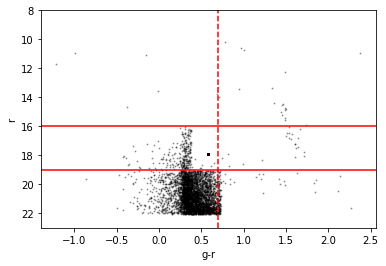

In [65]:
# Colour-magnitude plot

with warnings.catch_warnings(record=True) as W:
    #warnings.filterwarnings("ignore",category=RuntimeWarning)
    g = -2.5*np.log10(t['FLUX_G'])+22.5
    r = -2.5*np.log10(t['FLUX_R'])+22.5
    pl.scatter(g-r,r,s=1,alpha=0.3,c='k')
warning_summary(W)

pl.xlabel('g-r')
pl.ylabel('r')
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,8)

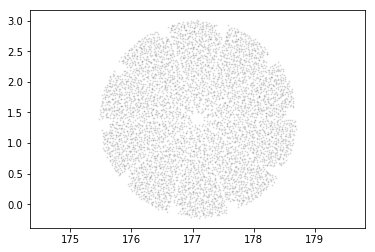

In [75]:
# Sky plot
pl.scatter(t['TARGET_RA'],t['TARGET_DEC'],c='k',s=1,alpha=0.1)
pl.axis('equal');

(0, 2)

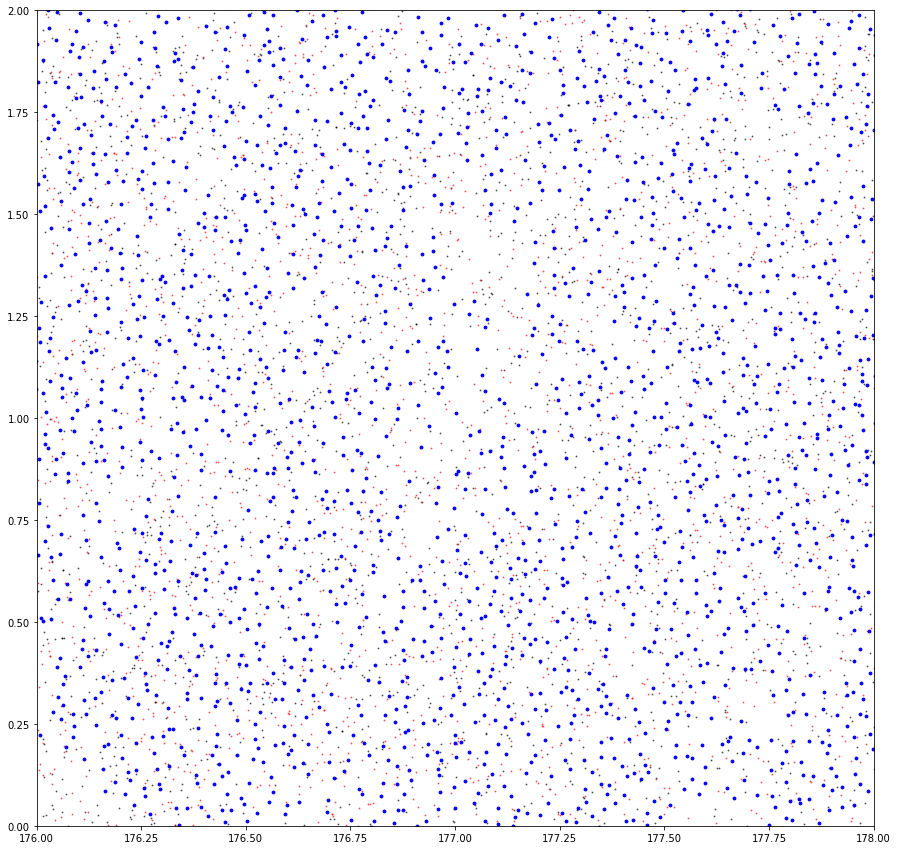

In [70]:
pl.figure(figsize=(15,15))
_ = mtl['PRIORITY'] == 1400
pl.scatter(mtl['RA'][_],mtl['DEC'][_],s=1,c='k',alpha=0.5)
_ = mtl['PRIORITY'] == 1500
pl.scatter(mtl['RA'][_],mtl['DEC'][_],s=1,c='r',alapha=0.5)

_ = t['PRIORITY'] == 1400
pl.scatter(t['TARGET_RA'][_],t['TARGET_DEC'][_],s=8,c='k')
_ = t['PRIORITY'] == 1500
pl.scatter(t['TARGET_RA'][_],t['TARGET_DEC'][_],s=8,c='r')
_ = t['PRIORITY'] > 1500
pl.scatter(t['TARGET_RA'][_],t['TARGET_DEC'][_],s=8,c='b')

pl.xlim(176,178)
pl.ylim(0,2)

In [80]:
mws_mask.names(917506)

['MWS_WD',
 'MWS_MAIN_RED_FAINT',
 'MWS_MAIN_RED_FAINT_NORTH',
 'MWS_MAIN_RED_FAINT_SOUTH']

In [82]:
t[t['DESI_TARGET']==0]

FIBER,LOCATION,NUMTARGET,PRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,SUBPRIORITY,HPXPIXEL,NUMOBS_MORE,OBSCONDITIONS
int32,int32,int16,int32,int64,int64,int64,int64,float64,float64,float32,float32,str8,int32,float32,float32,float32,str3,int16,int32,int32,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,str1,float64,int64,int32,int32


In [83]:
t = Table(fiber_data[0])
x = t[t['MWS_TARGET'] == mws_name_to_bits['BROAD (RED REJECT)']]

g = 22.5-2.5*np.log10(x['FLUX_G']) 
r = 22.5-2.5*np.log10(x['FLUX_R']) 
Table([g,r,g-r],names=['g','r','gmr'])
x['TARGETID','TARGET_RA','TARGET_DEC'][np.flatnonzero(~np.isfinite(g))]

TARGETID,TARGET_RA,TARGET_DEC
int64,float64,float64


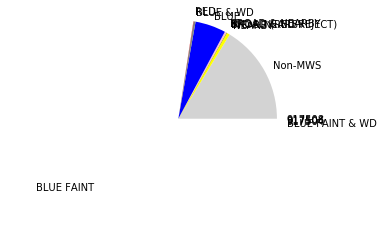

In [84]:
plot_pie_target_classes(fiber_data[0])

In [637]:
for itile in sorted(list(fiber_data.keys())):
    print('Tile {}'.format(itile))
    report_fibers_mws(fiber_data[itile],ncols=70)
    print()

Tile 0
WD                                                                     2         
NEARBY                                                                 32        
WD & NEARBY                                                            1         
BROAD & BROAD_NORTH & BROAD_SOUTH                                      2         
BROAD & NEARBY & BROAD_NORTH & BROAD_SOUTH                             16        
MAIN_BLUE & MAIN_BLUE_NORTH & MAIN_BLUE_SOUTH                          249       
WD & MAIN_BLUE & MAIN_BLUE_NORTH & MAIN_BLUE_SOUTH                     16        
MAIN_RED & MAIN_RED_NORTH & MAIN_RED_SOUTH                             2         
MAIN_BLUE_FAINT & MAIN_BLUE_FAINT_NORTH                     
& MAIN_BLUE_FAINT_SOUTH                                                3838      
WD & MAIN_BLUE_FAINT & MAIN_BLUE_FAINT_NORTH                
& MAIN_BLUE_FAINT_SOUTH                                                22        

(non-MWS targets)                                 

In [176]:
t = Table.read(fiber_files[0])
t[t['OBJTYPE']=='TGT']

FIBER,LOCATION,NUMTARGET,PRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,SUBPRIORITY,HPXPIXEL,NUMOBS_MORE,OBSCONDITIONS
int32,int32,int16,int32,int64,int64,int64,int64,float64,float64,float32,float32,str8,int32,float32,float32,float32,str3,int16,int32,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,str1,float64,int64,int32,int32
2,102,10,1,30787726290717838,2305843017803628544,0,1841,177.126371136,0.524992402869,-46.1005,-192.832,1771p005,0,256.555,198.328,5400.0,TGT,0,102,333956,3214,PSF,1.32878e+14,2.98724e+14,0.0309514,22.1576,28.6976,30.4203,3.38434,-4.22443,323.232,240.754,76.8885,2.55543,0.490577,0.912449,0.940148,0.966067,1088.33,840.577,115.297,757.433,460.756,61.8718,0.0,0.0,0.0,0.0,0.0,0.0,17.2217,22.3048,23.6437,17.2217,22.3048,23.6437,3796005930018177280,2.18713,1.44727,-7.30703,6.73377,S,0.139176262358,26972,1,7
12,65,10,1,30787732330513818,2305843052163366912,0,1841,177.01279923,0.697579075744,-18.1099,-149.753,1771p007,0,263.105,150.87,5400.0,TGT,0,65,335396,1434,PSF,6.71353e+14,1.53571e+15,0.027841,59.5826,80.7783,85.4031,18.815,10.574,71.8244,55.582,35.7507,2.76341,0.505798,0.92089,0.945997,0.969424,501.781,275.437,73.2227,347.046,180.204,42.3885,0.0,0.0,0.0,0.0,0.0,0.0,46.3492,62.8373,66.435,46.3492,62.8375,66.4355,3796059054469331712,-6.74466,9.86058,-1.49718,26.5549,S,0.456544382751,26972,1,7
15,142,7,1,30787726286521283,2305843052163366912,0,1841,176.966380967,0.430221872934,-6.79897,-216.567,1768p005,0,268.202,216.755,5400.0,TGT,0,142,333955,963,PSF,9.70813e+14,2.02799e+15,0.0304239,83.2462,118.113,131.667,30.4064,16.8504,97.8694,74.024,29.0387,2.72301,0.5276,0.913876,0.941137,0.966635,944.491,546.964,73.0721,648.527,348.847,42.6349,0.0,0.0,0.0,0.0,0.0,0.0,64.5625,91.6037,102.116,64.5625,91.6037,102.116,3796044760818187648,-12.1788,14.362,-4.84879,45.2343,S,0.60130807974,26972,1,7
20,74,7,1,30787732330512669,2305843017803628544,0,1841,177.012706673,0.639120593648,-18.1097,-164.256,1771p007,0,263.708,165.286,5400.0,TGT,0,74,335396,285,PSF,3.95582e+14,8.16584e+14,0.0282572,49.854,65.5587,69.9474,15.5669,8.77631,139.306,112.88,38.8578,2.62722,0.499121,0.919756,0.945212,0.968974,854.001,520.993,72.8105,584.787,331.434,42.084,0.0,0.0,0.0,0.0,0.0,0.0,38.7432,50.9478,54.3585,38.7432,50.9478,54.3585,3796057710143947392,-1.88481,5.43628,-6.80529,18.8852,S,0.40214087695,26972,1,7
28,85,7,1,30787726286524602,2305843052163366912,0,1841,176.921472753,0.624707692303,4.23793,-167.826,1768p005,0,271.447,167.916,5400.0,TGT,0,85,333955,4282,PSF,2.28559e+15,5.75217e+15,0.0296663,159.08,205.552,216.351,86.3965,50.3454,70.3819,54.033,28.945,2.56311,0.482903,0.915927,0.94256,0.967452,837.617,823.049,114.279,595.839,454.94,61.2109,0.0,0.0,0.0,0.0,0.0,0.0,122.594,158.408,166.73,122.594,158.408,166.73,3796056855446072576,-18.3034,36.4058,-11.8416,117.81,S,0.413147002399,26972,1,7
41,90,7,1,30787726290718230,2305843017803628544,0,1841,177.145814377,0.545949466781,-50.8572,-187.605,1771p005,0,254.832,194.434,5400.0,TGT,0,90,333956,3606,PSF,1.87821e+14,3.37482e+14,0.0300114,34.8851,37.9018,34.7477,8.68957,8.65018,235.91,201.613,73.9903,2.45271,0.469176,0.914992,0.94

In [175]:
t = Table.read(fiber_files[1])
t[t['OBJTYPE']=='TGT']

FIBER,LOCATION,NUMTARGET,PRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,TARGET_RA,TARGET_DEC,DESIGN_X,DESIGN_Y,BRICKNAME,FIBERSTATUS,DESIGN_Q,DESIGN_S,LAMBDA_REF,OBJTYPE,PETAL_LOC,DEVICE_LOC,BRICKID,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,SUBPRIORITY,HPXPIXEL,NUMOBS_MORE,OBSCONDITIONS
int32,int32,int16,int32,int64,int64,int64,int64,float64,float64,float32,float32,str8,int32,float32,float32,float32,str3,int16,int32,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,str1,float64,int64,int32,int32
0,95,7,1,30787726290716024,2305843017803628544,0,1841,177.24069793,0.439958665774,-3.24815,-172.327,1771p005,0,268.92,172.397,5400.0,TGT,0,95,333956,1400,PSF,1.4779e+14,3.43793e+14,0.0339525,19.6351,27.8756,31.1982,7.15684,1.79988,294.762,169.49,95.2358,2.59339,0.492799,0.904379,0.934538,0.962838,1209.72,395.15,155.313,705.853,269.53,76.8299,0.0,0.0,0.0,0.0,0.0,0.0,15.2504,21.6507,24.2314,15.2504,21.6507,24.2314,3796001428892793600,-2.20678,1.94216,-5.89875,7.01786,S,0.62920498755,26972,1,7
3,82,5,1500,30787726294910014,2305843009213693952,0,49,177.345588053,0.432225851359,-28.969,-174.293,1773p005,0,260.563,176.727,5400.0,TGT,0,82,333957,1086,PSF,1.05075e+14,3.17243e+14,0.0286788,11.8463,24.0018,34.2714,12.5068,5.81801,389.613,183.725,69.4121,2.62514,0.498724,0.918609,0.944418,0.968519,1219.68,386.624,121.192,698.947,265.042,57.2218,0.0,0.0,0.0,0.0,0.0,0.0,9.09247,18.4223,26.3046,9.09247,18.4223,26.3046,3795989059386979200,12.459,1.72237,-20.9921,7.32435,S,0.0955974013289,26972,1,7
6,119,8,1,30787720250921681,2305843052163366912,0,1841,177.209641595,0.363797709404,4.37211,-191.351,1771p002,0,271.309,191.456,5400.0,TGT,0,119,332516,4817,PSF,6.98423e+14,1.84135e+15,0.0334063,74.4237,97.9124,104.009,24.311,13.8119,103.558,67.0953,34.1167,2.62371,0.509236,0.905843,0.935557,0.963425,858.958,561.38,91.1139,598.916,305.537,46.8814,0.0,0.0,0.0,0.0,0.0,0.0,57.5093,75.6597,80.3707,57.5093,75.6597,80.3707,3795998753128547072,-15.1737,10.4465,-5.68808,38.169,S,0.247312624753,26972,1,7
8,72,7,1,30787726294910615,2305843017803628544,0,1841,177.404876704,0.462238658911,-43.4892,-166.866,1773p005,0,255.392,172.48,5400.0,TGT,0,72,333957,1687,PSF,4.14827e+14,1.19041e+15,0.0264632,47.4725,67.1407,75.41,20.3357,15.4951,196.225,120.02,78.3283,2.60209,0.489916,0.924653,0.948599,0.970915,1440.6,653.155,194.954,867.411,375.4,95.152,0.0,0.0,0.0,0.0,0.0,0.0,36.5899,51.7493,58.123,36.5899,51.7493,58.123,3796012630167507072,-15.5318,7.42904,-12.4729,25.067,S,0.601469162975,26972,1,7
10,132,8,1,30787720250921378,42949672960,0,0,177.153688105,0.349152767513,18.1209,-195.038,1771p002,0,275.308,195.938,5400.0,TGT,0,132,329631,4259,PSF,2.15762e+14,1.8892e+14,0.0229648,13.7736,43.1282,93.2842,47.6745,25.3124,194.55,78.4021,28.9336,2.67022,0.51697,0.934279,0.95524,0.974711,482.571,263.129,55.1019,312.537,162.893,29.5835,0.0,0.0,0.0,0.0,0.0,0.0,10.6281,33.2789,71.9806,10.6308,33.2831,71.9863,3795625670793683712,-12.5192,2.61337,-10.3846,9.94942,S,1.0,26969,1,7
13,129,7,1,30787720255114411,2305843052163366912,0,1841,177.284347832,0.288157077979,-14.0028,-210.368,1773p002,0,266.192,210.908,5400.0,TGT,0,129,332517,3243,PSF,2.77609e+15,7.16126e+15,0.0282986,220.671,303.908,320.576,74.9638,38.8449,39.4268,32.1417,30.1387,2.64516,0.511745,0.919643,0.945134,0.968929,1367.9,421

In [135]:
fdata = fits.getdata(os.path.join(outdir,'tile_00011.fits'),'FIBERASSIGN')

In [4]:
def circle_artists(self,**kwargs):
    from matplotlib.patches import Circle
    _kwargs = dict(lw=1,
                   alpha=1/12.0,
                   facecolor='c',
                   edgecolor='k')
    for _ in self.tiles:
        C = Circle((_.ra.value,_.dec.value),R_TILE,**kwargs)

In [5]:
f = pl.figure()
for _ in D.tiles:
    ax = pl.gca()
    C  = pl.Circle((_.ra.value,_.dec.value),R_TILE,lw=1,
                   alpha=1/12.0,facecolor='c',edgecolor='k')
    ax.add_artist(C)
    pl.scatter(_.ra.value,_.dec.value,s=1,c='k',zorder=10)

C  = pl.Circle((D.ra.value,D.dec.value),
               D.rdither_max.to(u.deg).value,
               lw=1,alpha=1.0,facecolor='None',edgecolor='r',zorder=10)
ax.add_artist(C)
pl.scatter(D.ra.value,D.dec.value,s=1,c='r',zorder=10)

pl.scatter(mtl['RA'],mtl['DEC'],c='k',s=1,alpha=0.1)

pl.axis('equal')
pl.xlim(C1.icrs.ra.value-3,C1.icrs.ra.value+3)
pl.ylim(C1.icrs.dec.value-3,C1.icrs.dec.value+3)
pl.xlabel('RA')
pl.ylabel('DEC')
pl.grid(c='lime');

NameError: name 'D' is not defined

In [8]:
PCEN_RA  = 10.0
PCEN_DEC = 60.0
pattern_center = coord.SkyCoord(PCEN_RA*u.deg, PCEN_DEC*u.deg,frame='icrs')
aframe         = pattern_center.skyoffset_frame()
wcs            = celestial_frame_to_wcs(aframe.origin)

# Hack...
wcs.wcs.crval = np.array([PCEN_RA,PCEN_DEC])
wcs.wcs.cdelt = np.array([1/60.0,1/60.0])

wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 10.0  60.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.016666666666666666  0.016666666666666666  
NAXIS : 0  0

In [9]:
cen_ra  = list()
cen_dec = list()
sw_width   = list()
sw_height  = list()
for h in sweep_headers:
    _wi = (h['RAMAX']-h['RAMIN'])*u.deg
    _hi = (h['DECMAX']-h['DECMIN'])*u.deg
    sw_width.append(_wi)
    sw_height.append(_hi)
    cen_ra.append(h['RAMIN']*u.deg + 0.5*_wi)
    cen_dec.append(h['DECMIN']*u.deg + 0.5*_hi)
sweep_centres = coord.SkyCoord(cen_ra,cen_dec,frame=aframe)

NameError: name 'sweep_headers' is not defined

In [17]:
# Radius in degrees to the middle of the outermost positioner
RADIUS        = desimodel.focalplane.get_tile_radius_deg()*u.deg
DPATTERN      = 12
NDITHER       = 12
DITHER_RADIUS = 10.0*u.arcmin

print('DESI tile radius = {}'.format(RADIUS))

R       = RADIUS-DITHER_RADIUS
print('Complete circle radius = {}'.format(R))

HSIDE   = R*np.sin(np.pi/6.0)

HAREA   = R*(3.0/2.0)*np.sqrt(3)
print('Complete hexagon area = {:6.3f}'.format(HAREA))

DX         = (R+HSIDE)
DY         = (R*np.sin(np.pi/3.0))
_POINTINGS = [coord.SkyCoord(*_,frame=aframe) for _ in ((0*u.deg,0*u.deg), 
                                                       (DX,DY), 
                                                       (DX,-DY))]
# Shift pointings to put vertex at PCEN
POINTINGS_RA  = list()
POINTINGS_DEC = list()
for p in _POINTINGS:
    _d = (0.5*R + HSIDE)
    POINTINGS_RA.append(p.lon-_d)
    POINTINGS_DEC.append(p.lat)
    
POINTINGS = coord.SkyCoord(POINTINGS_RA,POINTINGS_DEC,frame=aframe)
print(POINTINGS)

DESI tile radius = 1.6057735024174122 deg
Complete circle radius = 1.4391068357507455 deg
Complete hexagon area =  3.739 deg
<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    ( 10.,  60.)>): (lon, lat) in deg
    [(-1.43910684,  0.        ), ( 0.71955342,  1.24630308),
     ( 0.71955342, -1.24630308)]>


In [18]:
bbox_rect.bottom_left

<SkyCoord (ICRS): (ra, dec) in deg
    ( 56.97371596,  5.35115965)>

Total tiles = 36
Complete pattern area = 11.217 deg


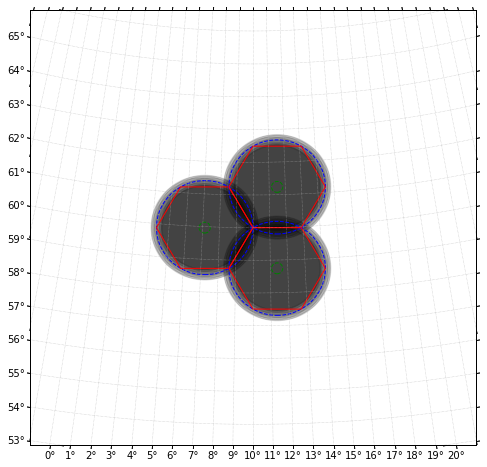

In [42]:
NTILES = len(POINTINGS)*NDITHER
print('Total tiles = {}'.format(NTILES))
print('Complete pattern area = {:6.3f}'.format(len(POINTINGS)*HAREA))

pl.figure(figsize=(8,8))
ax      = pl.subplot(projection=wcs)
patches = list()
kwargs  = dict(fill=True,edgecolor='k',facecolor='k',alpha=0.1,zorder=-10)

np.random.seed(2020)
for cen in POINTINGS:    
    C       = regions.CircleSkyRegion(center=cen,radius=DITHER_RADIUS)
    C_pixel = C.to_pixel(wcs)
    C_pixel.plot(ax=ax,ls='--',edgecolor='g',facecolor='none')

    C       = regions.CircleSkyRegion(center=cen,radius=R)
    C_pixel = C.to_pixel(wcs)
    C_pixel.plot(ax=ax,ls='--',edgecolor='b',facecolor='none')

    # Hexagon in a plane
    H = RegularPolygon((cen.lon.value,cen.lat.value),6,R.value,orientation=np.pi/6.0)
    HvX = H.get_verts()[:,0]    
    HvY = H.get_verts()[:,1]

    H = regions.PolygonSkyRegion(vertices=coord.SkyCoord(HvX, HvY, unit='deg', 
                                                         frame=aframe))
    H_pixel = H.to_pixel(wcs)
    H_pixel.plot(ax=ax,ls='solid',edgecolor='r',facecolor='none')
  
    for i in range(0,NDITHER):
        if DPATTERN == 'random':
            roff = np.sqrt(np.random.random())*DITHER_RADIUS
            toff = (np.random.random()*2-1)*np.pi
            xoff = roff*np.cos(toff)
            yoff = roff*np.sin(toff)
        else:
            xoff = DITHER_RADIUS*np.cos(2*i*np.pi/NDITHER)
            yoff = DITHER_RADIUS*np.sin(2*i*np.pi/NDITHER)

        _cen = coord.SkyCoord(cen.lon + xoff, cen.lat + yoff,frame=aframe)

        C       = regions.CircleSkyRegion(center=_cen,radius=R)
        C_pixel = C.to_pixel(wcs)
        C_pixel.plot(ax=ax,**kwargs)

BBOX     = regions.RectangleSkyRegion(center=bbox_cen,
                                      width=(ra_r-ra_l),
                                      height=(dec_t - dec_b))
BBOX_pixel = BBOX.to_pixel(wcs)
BBOX_pixel.plot(ax=ax,**kwargs)

pl.scatter(bbox_cen.fk5.ra,bbox_cen.fk5.dec,
           s=10,marker='.',zorder=10,transform=ax.get_transform('world'))

#pl.axis('equal')
ax = pl.gca()
ax.coords[0].set_ticks(spacing=1. * u.deg)
ax.coords[0].set_major_formatter('dd')
ax.coords[1].set_ticks(spacing=1. * u.deg)
ax.coords[1].set_major_formatter('dd')
pl.xlim(-400,400-1)
pl.ylim(-400,400-1)
ax.coords.grid(lw=0.5,ls=':')

Total tiles = 36
Complete pattern area = 11.217 deg


NameError: name 'idx_intersect' is not defined

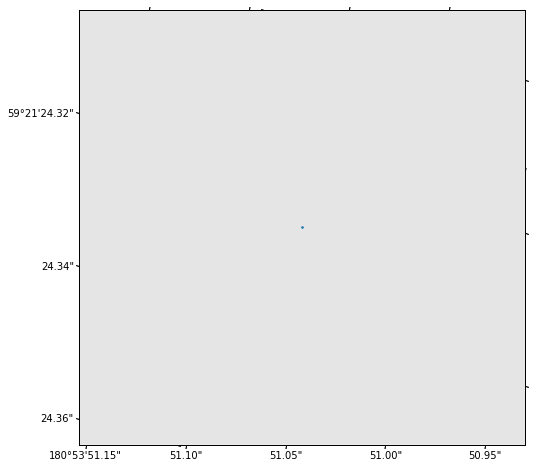

In [20]:
for i in idx_intersect:
    BBOX     = regions.RectangleSkyRegion(center=sweep_centres[i],
                                   width=sw_width[i],
                                   height=sw_height[i])
    BBOX_pixel = BBOX.to_pixel(wcs)
    BBOX_pixel.plot(ax=ax,color='lime',alpha=0.5)

#in_bbox  = BBOX.contains(sweep_centres,wcs)
#pl.scatter(sweep_centres.ra[in_bbox],sweep_centres.dec[in_bbox],
#           s=10,marker='.',zorder=10,c='r',transform=ax.get_transform('world'))

small = objects[::100000]
small_coord = coord.SkyCoord(small['RA'],small['DEC'],unit=u.deg)
pl.scatter(small_coord.ra,small_coord.dec,
           s=1,marker='.',zorder=10,c='r',transform=ax.get_transform('world'))

lbox = 5*60.0 # 
pl.axis('scaled')
pl.xlim(-lbox,lbox-1)
pl.ylim(-lbox,lbox-1)
ax.coords.grid(lw=0.5,ls=':')

In [ ]:
bbox_cen.

In [ ]:
objects['DEC'].max()

In [273]:
from desitarget.internal import sharedmem

def _select_targets_file(filename):
    objects = io.read_tractor(filename)
    return objects

pool = sharedmem.MapReduce(np=4)
with pool:
    objects = pool.map(_select_targets_file, [sweep_files[i] for i in idx_intersect])

In [25]:
objects = np.concatenate(objects)

(1798,)

In [109]:
brick_centres = coord.SkyCoord(brick_table['RA'],brick_table['DEC'])
brick_centres

<SkyCoord (ICRS): (ra, dec) in deg
    [( 180., -90.  ), (  18., -89.75), (  54., -89.75), ...,
     ( 306.,  89.75), ( 342.,  89.75), ( 180.,  90.  )]>

In [104]:
bb = brick.Bricks()
bb.brickname((BBOX.center.ra + 0.5*BBOX.width).value, 
             (BBOX.center.dec + 0.5*BBOX.height).value)

'0129p645'

Look for targets in this region using the sweeps.

In [38]:
from desitarget import io
import os

In [44]:
from desiutil import brick

In [115]:
from astropy.io import fits 

In [117]:
len(sweep_files)

292

In [147]:
width   = list()
height  = list()
cen_ra  = list()
cen_dec = list()


array([ 13,  87,  90, 272])

In [52]:
POINTINGS

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     ( 10.,  60.)>): (lon, lat) in deg
     (-2.24199359,  0.)>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     ( 10.,  60.)>): (lon, lat) in deg
     ( 1.12099679,  1.9416234)>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     ( 10.,  60.)>): (lon, lat) in deg
     ( 1.12099679, -1.9416234)>]

In [40]:
sweeps = dict()
for sweep_file in sweep_files:
    bn = io.brickname_from_filename(os.path.basename(sweep_file))
    sweeps[bn] = sweep_file

ValueError: Invalid tractor brick file: sweep-320m015-330m010.fits!

In [24]:
bricks_near_target

In [29]:
PCEN_RA  = 10.0
PCEN_DEC = 60.0

In [27]:
desiutil.absolute_import

ModuleNotFoundError: No module named 'imaginglss'

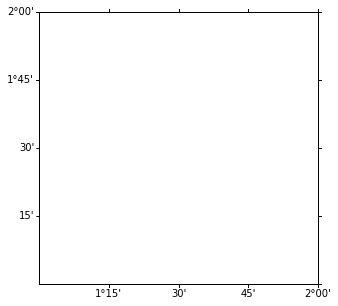

In [6]:
_wcs = celestial_frame_to_wcs(coord.ICRS(),'AIT')

pl.figure(figsize=(5,5))
ax      = pl.subplot(projection=_wcs)

H = RegularPolygon((10,60),6,R.value,orientation=np.pi/6.0)
HvX = H.get_verts()[:,0]    
HvY = H.get_verts()[:,1]

H = regions.PolygonSkyRegion(vertices=coord.SkyCoord(HvX, HvY, unit='deg', 
                                                     frame='icrs'))
H_pixel = H.to_pixel(_wcs)
H_pixel.plot(ax=ax,ls='solid',edgecolor='r',facecolor='none')


In [7]:
_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIT'  'DEC--AIT'  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 0  0

In [8]:
C       = regions.CircleSkyRegion(center=_POINTINGS[0],radius=DITHER_RADIUS)
C_pixel = C.to_pixel(wcs)
C_pixel

<CirclePixelRegion(PixCoord(x=-1.0, y=-1.0000000000002105), radius=10.000000000381192)>

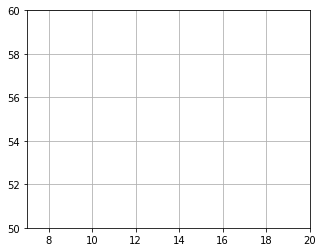

In [126]:

pl.figure()
H_pixel.plot(ax=ax,ls='solid',edgecolor='r',facecolor='none')

lbox = 100
pl.axis('scaled')
pl.xlim(7,20)
pl.ylim(50,60)
pl.grid()

In [104]:
celestial_frame_to_wcs??

Signature: celestial_frame_to_wcs(frame, projection='TAN')
Source:   
def celestial_frame_to_wcs(frame, projection='TAN'):
    """
    For a given coordinate frame, return the corresponding WCS object.

    Note that the returned WCS object has only the elements corresponding to
    coordinate frames set (e.g. ctype, equinox, radesys).

    Parameters
    ----------
    frame : :class:`~astropy.coordinates.baseframe.BaseCoordinateFrame` subclass instance
        An instance of a :class:`~astropy.coordinates.baseframe.BaseCoordinateFrame`
        subclass instance for which to find the WCS
    projection : str
        Projection code to use in ctype, if applicable

    Returns
    -------
    wcs : :class:`~astropy.wcs.WCS` instance
        The corresponding WCS object

    Examples
    --------

    ::

        >>> from astropy.wcs.utils import celestial_frame_to_wcs
        >>> from astropy.coordinates import FK5
        >>> frame = FK5(equinox='J2010')
        >>> wcs = celestial_fra

In [14]:
class QuickRect():
    def __init__(self,tr,bl):
        self.top_right   = tr
        self.bottom_left = bl
    
    def intersects(self, other):
        c1 = self.top_right.ra    < other.bottom_left.ra
        c2 = self.bottom_left.ra  > other.top_right.ra
        c3 = self.top_right.dec   < other.bottom_left.dec
        c4 = self.bottom_left.dec > other.top_right.dec
        return not (c1 or c2 or c3 or c4)

In [16]:
# This is all in some offset frame
# Define the rectangle around the pattern
dec_t = np.max(POINTINGS.transform_to('icrs').ra) + RADIUS + DITHER_RADIUS
dec_b = np.min(POINTINGS.transform_to('icrs').ra) - RADIUS - DITHER_RADIUS
ra_r  = np.max(POINTINGS.transform_to('icrs').dec) + RADIUS + DITHER_RADIUS
ra_l  = np.min(POINTINGS.transform_to('icrs').dec) - RADIUS - DITHER_RADIUS
print(ra_l,ra_r)

bbox_cen = coord.SkyCoord(pattern_center.ra-(0.5*R),
                          pattern_center.dec,frame=aframe)

bbox_rect = QuickRect(coord.SkyCoord(ra_r,dec_t,unit=u.deg),
                      coord.SkyCoord(ra_l,dec_b,unit=u.deg))

56d58m25.3774s 63d00m38.2035s


In [15]:
I = list()
for _ in sweep_headers:
    ramin  = _['RAMIN']
    ramax  = _['RAMAX']
    decmin = _['DECMIN']
    decmax = _['DECMAX']

    # ICRS frame
    tr = coord.SkyCoord(ramax*u.deg, decmax*u.deg)
    bl = coord.SkyCoord(ramin*u.deg, decmin*u.deg)

    sweep_rect = QuickRect(tr,bl)
    is_intersect = sweep_rect.intersects(bbox_rect)
    I.append(is_intersect)
    if is_intersect:
        print('Intersect:',ramin,ramax,decmin,decmax)
        
idx_intersect = np.flatnonzero(np.array(I))

56d58m25.3774s 63d00m38.2035s


NameError: name 'sweep_headers' is not defined

94


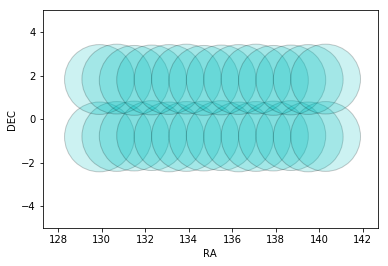

In [146]:
bgs_tiles = Table.read('/global/homes/a/apcooper/projects/fiberassign_sv/data/bgs_sv.fits')
print(len(bgs_tiles))

f = pl.figure()
for _ in bgs_tiles:
    ax = pl.gca()
    C  = pl.Circle((_['RA'],_['DEC']),R_TILE,lw=1,
                   alpha=0.2,facecolor='c',edgecolor='k')
    ax.add_artist(C)
pl.axis('equal')
pl.xlim(120,150)
pl.ylim(-5,5)
pl.xlabel('RA')
pl.ylabel('DEC');

In [23]:
%%time

# Targets are read from a pre-existing targets file.

reset_targets = False

columns=['TARGETID','SUBPRIORITY', 'BRICKID', 'BRICK_OBJID', 'REF_ID',
        'PMRA', 'PMDEC', 'PMRA_IVAR', 'PMDEC_IVAR',
        'FLUX_G', 'FLUX_R', 'FLUX_Z',
        'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z',
        'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'RA_IVAR', 'DEC_IVAR',
        'EBV', 'MORPHTYPE',
        'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
        'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'HPXPIXEL',
        'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z',
        'PHOTSYS',
        'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 
        'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 
        'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 
        'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 
        'RA', 'DEC', 'SUBPRIORITY', 'BRICKNAME',
        'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET']
    
if (not os.path.exists(local_targets_path)) or reset_targets:

    print('Started reading {}'.format(targets_path))
    targetdata = fitsio.read(targets_path, 'TARGETS', columns=columns)

    ra_min  = C1.icrs.ra.value - 5
    ra_max  = C1.icrs.ra.value + 5
    dec_min = C1.icrs.dec.value - 5
    dec_max = C1.icrs.dec.value + 5
    
    # Clip targets with wrap
    print('Trimming targets by location')
    targetcoord = coord.SkyCoord(targetdata['RA'],targetdata['DEC'],
                                 frame='icrs',unit='deg')
    
    ii = targetcoord.separation(C1) < 5*u.deg
    targetdata = targetdata[ii]
    
    print('Done reading target data to compute mtl + std')
    
    Table(targetdata).write(local_targets_path,overwrite=Ture)
    print('Cached targets to local path: {}'.format(local_targets_path))
else:
    targetdata = fitsio.read(local_targets_path, 'TARGETS', columns=columns)

CPU times: user 531 ms, sys: 47.1 ms, total: 578 ms
Wall time: 677 ms
